# BYU CS 473 — K-Nearest Neighbors

In this assignment, you will explore **KNN classification** using different distance metrics, understand the **curse of dimensionality**, and learn how KNN can be adapted for **open set recognition** and **out-of-distribution (OOD) detection**.

---

## Learning Goals
- Understand and compare different distance metrics in KNN
- Explore the effect of high-dimensional data (curse of dimensionality)
- Implement open set recognition with KNN
- Apply KNN for simple OOD detection


## 1. Loading the Iris Dataset

We begin with the Iris dataset.


In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Exercise 1
Print the shapes of the training and test sets, and display the first 5 rows of `X_train`.


In [2]:
# Your code here
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nX_train:\n", X_train[:5])

X_train shape: (105, 4)
X_test shape: (45, 4)
y_train shape: (105,)
y_test shape: (45,)

X_train:
 [[-0.41600969 -1.51316008 -0.03296571 -0.26238682]
 [ 0.55333328 -0.59237301  0.76275827  0.3957741 ]
 [ 0.67450115  0.09821729  0.99010798  0.79067065]
 [ 0.91683689 -0.13197948  0.36489628  0.26414192]
 [ 1.64384411  1.24920112  1.33113254  1.71209594]]


## 2. KNN with Different Distance Metrics

KNN relies on a distance function to measure similarity. Common choices include:

- **Euclidean** (straight-line distance)  
- **Manhattan** (sum of absolute differences)  
- **Chebyshev** (max difference)  
- **Mahalanobis** (accounts for correlations between features)  


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

V = np.cov(X_train, rowvar=False)
VI = np.linalg.inv(V)

distances = ["euclidean", "manhattan", "chebyshev", "mahalanobis"]

for d in distances:
    if d == "mahalanobis":
        knn = KNeighborsClassifier(
            n_neighbors=5,
            metric=d,
            metric_params={"V": V, "VI": VI}
        )
    else:
        knn = KNeighborsClassifier(n_neighbors=5, metric=d)

    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Metric: {d}, Accuracy: {acc:.3f}")

Metric: euclidean, Accuracy: 1.000
Metric: manhattan, Accuracy: 1.000
Metric: chebyshev, Accuracy: 0.956
Metric: mahalanobis, Accuracy: 0.889


### Exercise 2
Add **Mahalanobis distance** to the code above.  
Hint: compute the covariance matrix and pass it via `metric_params`.  

Which distance metric performed best? Why might that be the case?

Euclidean and Manhattan distances performed best. This is likely because the features are roughly independent and similarly scaled, making simple geometric distances effective. Chebyshev underperforms because it ignores multi-feature differences, and Mahalanobis doesn’t help much since the feature correlations are modest and the clusters are already well-separated without needing covariance adjustment.

## 3. Curse of Dimensionality

As the number of features increases, distances between points become less meaningful.  
We will test KNN on synthetic datasets with increasing dimensionality.


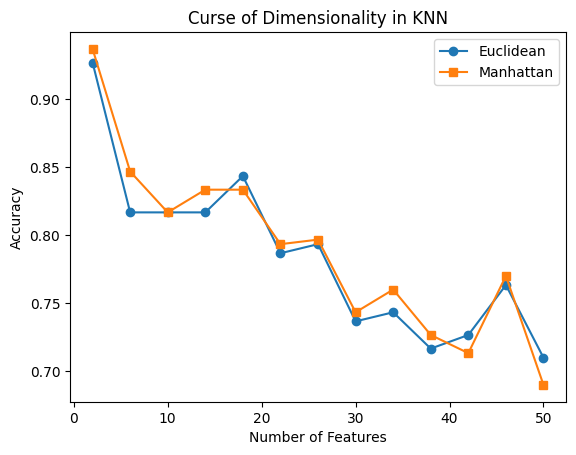

In [4]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

dims = range(2, 51, 4)
euclidean_acc = []
manhattan_acc = []

for d in dims:
    X_high, y_high = make_classification(
        n_samples=1000,
        n_features=d,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        random_state=42
    )
    X_tr, X_te, y_tr, y_te = train_test_split(X_high, y_high, test_size=0.3, random_state=42)

    # Euclidean
    knn_euc = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    knn_euc.fit(X_tr, y_tr)
    euclidean_acc.append(knn_euc.score(X_te, y_te))

    # Manhattan
    knn_man = KNeighborsClassifier(n_neighbors=5, metric="manhattan")
    knn_man.fit(X_tr, y_tr)
    manhattan_acc.append(knn_man.score(X_te, y_te))

# Plot both curves
plt.plot(dims, euclidean_acc, marker="o", label="Euclidean")
plt.plot(dims, manhattan_acc, marker="s", label="Manhattan")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Curse of Dimensionality in KNN")
plt.legend()
plt.show()


### Exercise 3
Modify the code above to also test **Manhattan distance** and plot both curves together.

What happens to accuracy as dimensionality increases? Why?

The general trend is that accuracy decreases with more dimensions. The basic reason for this is that some features are going to be inherently more useful than others, and adding less useful metrics just creates noise and confusion.

## 4. Open Set Recognition

KNN assumes all test samples belong to known classes. But in practice, a test point may not belong to any training class.

We simulate this by generating a synthetic "unknown" dataset.


In [5]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

# Synthetic unknown samples
X_unknown, _ = make_classification(n_samples=200, n_features=4, n_classes=1, random_state=99)

# Fit KNN on known data
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(X_train, y_train)

# Get distances to the nearest neighbor
distances, indices = knn.kneighbors(X_unknown, n_neighbors=1)
distances = distances.flatten()

# Set a threshold for "unknown" classification
threshold = 1.5  # adjust based on your data scale

# Classify as unknown if distance exceeds threshold
predicted_labels = []
for i, dist in enumerate(distances):
    if dist > threshold:
        predicted_labels.append("unknown")
    else:
        predicted_labels.append(knn.predict(X_unknown[i].reshape(1, -1))[0])

predicted_labels = np.array(predicted_labels)
print("Unique predictions including 'unknown':", np.unique(predicted_labels))


Unique predictions including 'unknown': ['0' '1' '2' 'unknown']


### Exercise 4
Modify the code to compute the distance to the nearest neighbor for each unknown sample.  
If the distance is above a threshold, classify it as **unknown**.

How does thresholding improve open set recognition?

With thresholding, the classifier can explicitly reject inputs that are likely from a class it has never seen.

## 5. Out-of-Distribution (OOD) Detection

OOD detection identifies samples that do not belong to the same distribution as the training data.


Average distance (in-distribution): 0.31853062619139316
Average distance (OOD): 1.2213708916568842


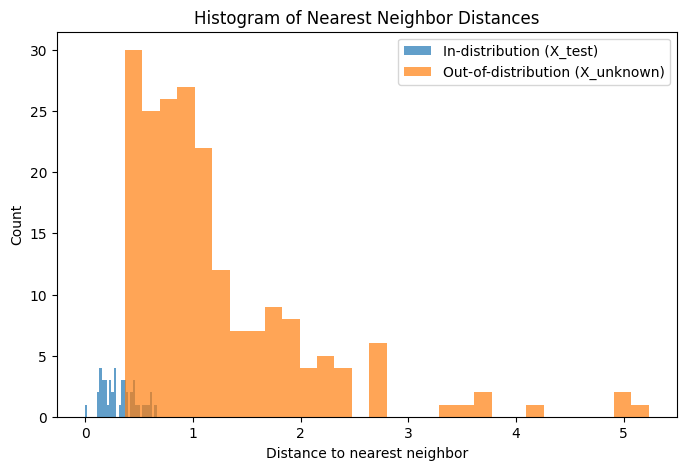

In [6]:
from sklearn.metrics import pairwise_distances

in_dist = pairwise_distances(X_test, X_train).min(axis=1)
out_dist = pairwise_distances(X_unknown, X_train).min(axis=1)

print("Average distance (in-distribution):", np.mean(in_dist))
print("Average distance (OOD):", np.mean(out_dist))

# Plot histograms
plt.figure(figsize=(8,5))
plt.hist(in_dist, bins=30, alpha=0.7, label="In-distribution (X_test)")
plt.hist(out_dist, bins=30, alpha=0.7, label="Out-of-distribution (X_unknown)")
plt.xlabel("Distance to nearest neighbor")
plt.ylabel("Count")
plt.title("Histogram of Nearest Neighbor Distances")
plt.legend()
plt.show()

## Exersise 5
Plot histograms of `in_dist` and `out_dist` on the same figure.  
What do you observe?
Suggest a thresholding rule to separate in-distribution from OOD samples.

The vast majority of OOD samples are more than about .75 units away from their nearest neighbor. "About .75 units" is also the furthest an ID sample is from its nearest neighbor. As such, .75 seems a reasonable threshold.

## 6. Reflection

1. Which distance metric was most robust?  
2. How did dimensionality affect KNN performance?  
3. Why is open set recognition important?  
4. How might KNN be adapted for stronger OOD detection?  


1. For this dataset, Euclidean and Manhattan distances performed best.
2. KNN performance falls as dimensionality increases.
3. Open set recognition is important because it allows the classifier to explicitly reject inputs that are likely from a class it has never seen.
4. KNN could be adapted for stronger OOD detection by using weighted distances based on local density.